In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from PIL import Image

# Check for fronts in the vicinity of the NY Bight
using data downloaded from the NOAA archive using `get_all_sfc_maps.py`

In [2]:
startdate = '2019-09-01'
enddate = '2021-10-01'
outdir = 'sfc'

#analysis = 'namussfc' # CONUS
analysis = 'usfntsfc' # fronts

In [3]:
datetimes = pd.date_range(startdate,enddate,freq='3h')

In [4]:
imgpaths = [f'{outdir}/{dt.year}/{analysis}{dt.strftime("%Y%m%d%H")}.gif' for dt in datetimes]
imgexists = [os.path.isfile(fpath) for fpath in imgpaths]
assert all(imgexists)

## check an example map

[[  0   0   0]
 [  0   0 255]
 [  0 178 238]
 [139   0   0]
 [145  44 238]
 [255   0   0]
 [255 130  71]
 [255 228 220]
 [255 255 255]]


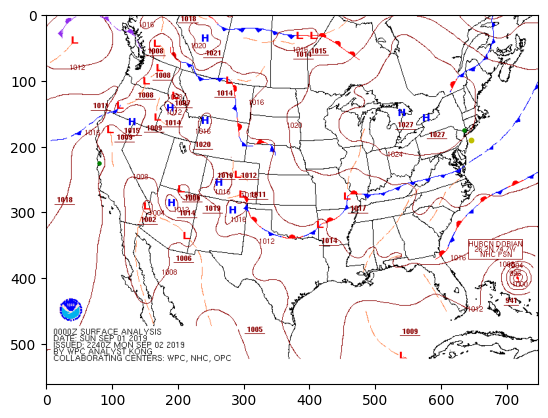

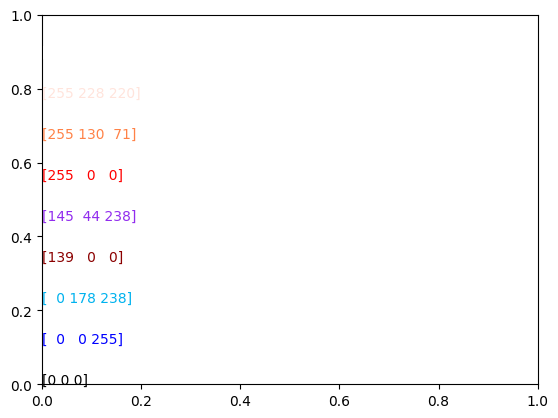

In [5]:
x0,y0 = 645,190
imgsize = [562,748] # height, width in pixels
scale = 4128 / np.sqrt((635-80)**2 + (175-225)**2) # estimated km / pixel

Rsearch = 250./scale # km on map

imgpath = imgpaths[0]
img = np.asarray(Image.open(imgpath).convert("RGB"))
assert list(img.shape[:2]) == imgsize
plt.imshow(img)
plt.scatter([80],[225],s=5,color='g')
plt.scatter([635],[175],s=5,color='g')
# dist is 2565 mi from google maps
plt.scatter([x0],[y0],s=10,color='y')

# check colors
colorlist = img.reshape((562*748,3),order='F')
colorlist = np.unique(colorlist,axis=0)
print(colorlist)
fig,ax = plt.subplots()
for i,col in enumerate(colorlist):
    ax.text(0,i/len(colorlist),str(col),color=col/255,transform=ax.transAxes)

In [6]:
frontcolor = {
    'cold': [0,0,255],
    'warm': [255,0,0],
    'occluded': [145,44,238],
}

## OK, now do the analysis

In [7]:
x = np.arange(imgsize[1])
y = np.arange(imgsize[0])
xx,yy = np.meshgrid(x,y)

mask = ((xx - x0)**2 + (yy - y0)**2) < Rsearch**2
np.count_nonzero(mask)

3577

In [8]:
subx = slice(int(x0-1.5*Rsearch),int(x0+1.5*Rsearch+1))
suby = slice(int(y0-1.5*Rsearch),int(y0+1.5*Rsearch+1))
masksub = mask[suby,subx]
np.count_nonzero(masksub)

3577

Need to remove "<font color='blue'>H</font>" and "<font color='red'>L</font>" from map to eliminate false front detections from the iamge

In [9]:
def remove_H_L(img):
    # find blue H
    blues_r, blues_c = np.where((img == frontcolor['cold']).all(axis=2))
    #print(blues_r-blues_r[0])
    #print(blues_c-blues_c[0])
    for row,col in zip(blues_r,blues_c):
        if np.all((img[row  :row+11, col  :col+3 ] == frontcolor['cold']).all(axis=2)) and \
           np.all((img[row  :row+11, col+7:col+10] == frontcolor['cold']).all(axis=2)) and \
           np.all((img[row+4:row+6 , col  :col+10] == frontcolor['cold']).all(axis=2)):
            # found left vert, right vert, middle horiz
            img[row  :row+11, col  :col+3 , :] = 255
            img[row  :row+11, col+7:col+10, :] = 255
            img[row+4:row+6 , col  :col+10, :] = 255
            #print('removed H')
    # find red L
    reds_r, reds_c = np.where((img == frontcolor['warm']).all(axis=2))
    #print(reds_r-reds_r[0])
    #print(reds_c-reds_c[0])
    for row,col in zip(reds_r,reds_c):
        if np.all((img[row  :row+11, col  :col+3 ] == frontcolor['warm']).all(axis=2)) and \
           np.all((img[row+9:row+11, col  :col+10] == frontcolor['warm']).all(axis=2)):
            # found left vert, bottom horiz
            img[row  :row+11, col  :col+3 , :] = 255
            img[row+9:row+11, col  :col+10, :] = 255
            #print('removed L')
    return img

apply threshold so that each analysis snapshot more accurately represents whether a human analyst might identify a front as being "in the region" for a given map

In [10]:
def check_front(row,plot=False,thresh=35):
    """threshold is how many pts within circle"""
    dt = row.name
    imgpath = f'{outdir}/{dt.year}/{analysis}{dt.strftime("%Y%m%d%H")}.gif'
    print('\rChecking',imgpath,end='')
    img = np.asarray(Image.open(imgpath).convert("RGB"))
    #assert list(img.shape[:2]) == imgsize
    if list(img.shape[:2]) != imgsize:
        assert img.shape[0] == imgsize[0] # at least height matches
        img = img[:,:imgsize[1],:]
    imgsub = img[suby,subx,:]
    if plot:
        plt.figure()
        plt.imshow(imgsub)

    imgsub_noletters = remove_H_L(imgsub)
    maskedimg = np.where(masksub[:,:,np.newaxis], imgsub, 0)
    colorlist = maskedimg.reshape((maskedimg.shape[0]*maskedimg.shape[1],3),order='F')
    if plot:
        print(np.unique(colorlist,axis=0))
        plt.figure()
        plt.imshow(imgsub_noletters)
        plt.figure()
        plt.imshow(maskedimg)
    if thresh == 0:
        uniquecolorlist = np.unique(colorlist,axis=0)
        has_warm = any([all(rgb == frontcolor['warm']    ) for rgb in uniquecolorlist])
        has_cold = any([all(rgb == frontcolor['cold']    ) for rgb in uniquecolorlist])
        has_occl = any([all(rgb == frontcolor['occluded']) for rgb in uniquecolorlist])
    else:
        # this is slower...
        has_warm = np.count_nonzero((colorlist == frontcolor['warm']    ).all(axis=1)) > thresh
        has_cold = np.count_nonzero((colorlist == frontcolor['cold']    ).all(axis=1)) > thresh
        has_occl = np.count_nonzero((colorlist == frontcolor['occluded']).all(axis=1)) > thresh
    return has_warm, has_cold, has_occl

In [12]:
%%time
df = pd.DataFrame(index=datetimes, columns=['warm','cold','occluded'])
df = df.apply(check_front, axis=1, result_type='broadcast')

# CPU times: user 41.5 s, sys: 6.72 s, total: 48.2 s
# Wall time: 52.3 s

Checking sfc/2021/usfntsfc2021100100.gifCPU times: user 42.4 s, sys: 7.23 s, total: 49.6 s
Wall time: 54.5 s


In [13]:
df.to_csv('sfc_analysis_fronts.csv')